In [6]:
import pandas as pd
import shap
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('wandb_export_2024-11-01T10_44_06.475+01_00.csv')
data = data.drop(columns=["Name","Created","Runtime","Hostname","Notes","State","Tags","trainer/global_step", "epoch"])
data = data.dropna()
data = data[data.test_f1 > 0.1]

# Define features and target variable
X = data[["data.frequency_masking_para","data.time_masking_para","data.time_warp_w"]]
y = data['test_precision']


# Initialize and train the tuned XGBRegressor model
# Define the model with specific parameters
model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

model.fit(X, y)

# Initialize SHAP explainer with the trained model, using test data for SHAP analysis
explainer = shap.Explainer(model, X)
shap_values = explainer(X)


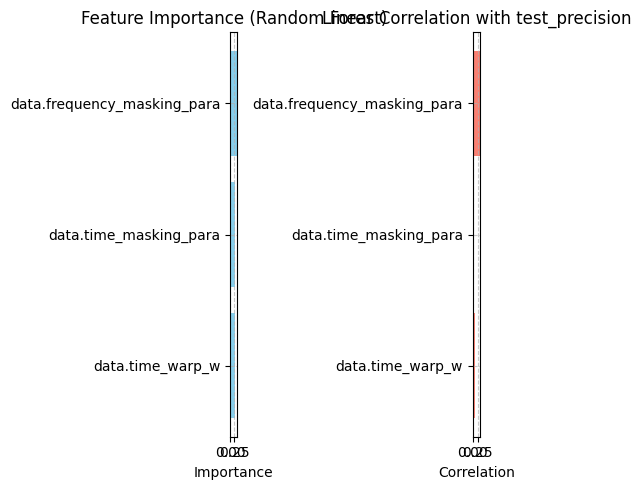

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import numpy as np

# Select relevant columns and remove rows with NaN in 'test_precision'
hyperparameters = ['data.time_warp_w', 'data.time_masking_para', 'data.frequency_masking_para']
filtered_data_for_model = data.dropna(subset=['test_precision'])[hyperparameters + ['test_precision']].copy()

# Separate features and target variable
X = filtered_data_for_model[hyperparameters]
y = filtered_data_for_model['test_precision']

# Standardize features to handle different ranges
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train a Random Forest model to predict test_precision
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_scaled, y)

# Calculate feature importance from the trained model
importances = rf.feature_importances_

# Calculate correlation of each hyperparameter with test_precision
correlations = filtered_data_for_model.corr()['test_precision'][hyperparameters].values

# Plotting feature importance and correlation side by side
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

# Plot feature importance
ax[0].barh(hyperparameters, importances, color='skyblue')
ax[0].set_title('Feature Importance (Random Forest)')
ax[0].set_xlabel('Importance')
ax[0].grid(True, linestyle='--', alpha=0.7)

# Plot correlation with test_precision
ax[1].barh(hyperparameters, correlations, color='salmon')
ax[1].set_title('Linear Correlation with test_precision')
ax[1].set_xlabel('Correlation')
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


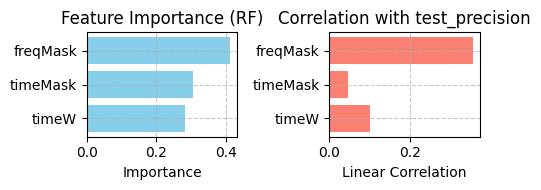

In [23]:
# Renaming columns for clarity in the plots
renamed_hyperparameters = ['timeW', 'timeMask', 'freqMask']

# Plotting feature importance and correlation with renamed hyperparameters
fig, ax = plt.subplots(1, 2, figsize=(5, 2))

# Plot feature importance with new labels
ax[0].barh(renamed_hyperparameters, importances, color='skyblue')
ax[0].set_title('Feature Importance (RF)')
ax[0].set_xlabel('Importance')
ax[0].grid(True, linestyle='--', alpha=0.7)

# Plot correlation with test_precision with new labels
ax[1].barh(renamed_hyperparameters, correlations, color='salmon')
ax[1].set_title('Correlation with test_precision')
ax[1].set_xlabel('Linear Correlation')
ax[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


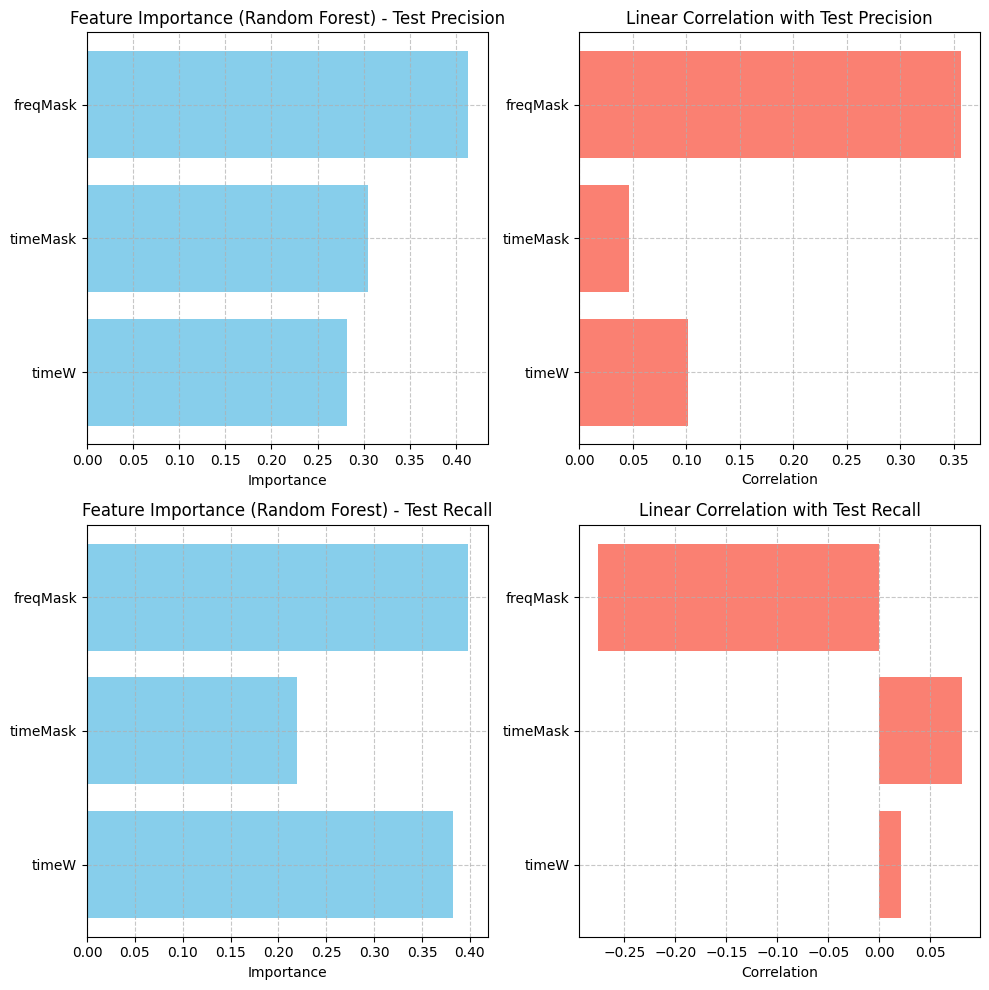

In [24]:
# Preparing the data for both test_precision and test_recall analyses

# Filter data for rows without NaNs in both test_precision and test_recall
filtered_data_for_both = data.dropna(subset=['test_precision', 'test_recall'])[hyperparameters + ['test_precision', 'test_recall']].copy()

# Separate features and target variables for test_precision and test_recall
X_both = filtered_data_for_both[hyperparameters]
y_precision = filtered_data_for_both['test_precision']
y_recall = filtered_data_for_both['test_recall']

# Standardize features
X_scaled_both = scaler.fit_transform(X_both)

# Train two Random Forest models for test_precision and test_recall
rf_precision = RandomForestRegressor(random_state=42, n_estimators=100)
rf_recall = RandomForestRegressor(random_state=42, n_estimators=100)
rf_precision.fit(X_scaled_both, y_precision)
rf_recall.fit(X_scaled_both, y_recall)

# Calculate feature importance for both models
importances_precision = rf_precision.feature_importances_
importances_recall = rf_recall.feature_importances_

# Calculate correlations for both metrics
correlations_precision = filtered_data_for_both.corr()['test_precision'][hyperparameters].values
correlations_recall = filtered_data_for_both.corr()['test_recall'][hyperparameters].values

# Plotting feature importance and correlation for both test_precision and test_recall
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Plot feature importance for test_precision
ax[0, 0].barh(renamed_hyperparameters, importances_precision, color='skyblue')
ax[0, 0].set_title('Feature Importance (Random Forest) - Test Precision')
ax[0, 0].set_xlabel('Importance')
ax[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot correlation with test_precision
ax[0, 1].barh(renamed_hyperparameters, correlations_precision, color='salmon')
ax[0, 1].set_title('Linear Correlation with Test Precision')
ax[0, 1].set_xlabel('Correlation')
ax[0, 1].grid(True, linestyle='--', alpha=0.7)

# Plot feature importance for test_recall
ax[1, 0].barh(renamed_hyperparameters, importances_recall, color='skyblue')
ax[1, 0].set_title('Feature Importance (Random Forest) - Test Recall')
ax[1, 0].set_xlabel('Importance')
ax[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot correlation with test_recall
ax[1, 1].barh(renamed_hyperparameters, correlations_recall, color='salmon')
ax[1, 1].set_title('Linear Correlation with Test Recall')
ax[1, 1].set_xlabel('Correlation')
ax[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


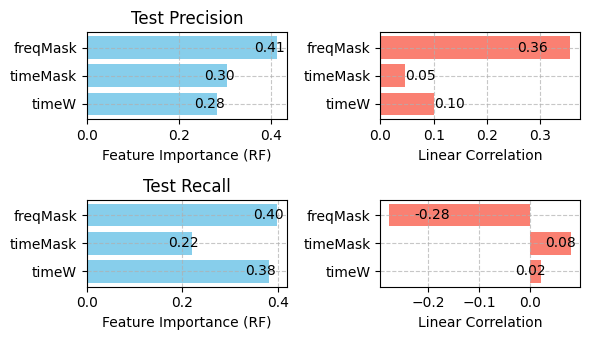

In [68]:
# Plotting feature importance and correlation for both test_precision and test_recall with values inside each bar
fig, ax = plt.subplots(2, 2, figsize=(6, 3.5))

# Plot feature importance for test_precision with values
ax[0, 0].barh(renamed_hyperparameters, importances_precision, color='skyblue')
ax[0, 0].set_title('Test Precision')
ax[0, 0].set_xlabel('Feature Importance (RF)')
for i, v in enumerate(importances_precision):
    ax[0, 0].text(v - 0.05, i, f'{v:.2f}', va='center')
ax[0, 0].grid(True, linestyle='--', alpha=0.7)

# Plot correlation with test_precision with values
ax[0, 1].barh(renamed_hyperparameters, correlations_precision, color='salmon')
ax[0, 1].set_title('')
ax[0, 1].set_xlabel('Linear Correlation')
for i, v in enumerate(correlations_precision):
    ax[0, 1].text(v -0.0 if v <= 0.3 else v - 0.1, i, f'{v:.2f}', va='center')
ax[0, 1].grid(True, linestyle='--', alpha=0.7)

# Plot feature importance for test_recall with values
ax[1, 0].barh(renamed_hyperparameters, importances_recall, color='skyblue')
ax[1, 0].set_title('Test Recall')
ax[1, 0].set_xlabel('Feature Importance (RF)')
for i, v in enumerate(importances_recall):
    ax[1, 0].text(v - 0.05, i, f'{v:.2f}', va='center')
ax[1, 0].grid(True, linestyle='--', alpha=0.7)

# Plot correlation with test_recall with values
ax[1, 1].barh(renamed_hyperparameters, correlations_recall, color='salmon')
ax[1, 1].set_title('')
ax[1, 1].set_xlabel('Linear Correlation')
for i, v in enumerate(correlations_recall):
    ax[1, 1].text(v - 0.05 if v >= 0 else v + 0.05, i, f'{v:.2f}', va='center')
ax[1, 1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
